In [85]:
from azure.identity import DefaultAzureCredential
from azure.storage.filedatalake import DataLakeServiceClient
import io
import pandas as pd
import plotly.express as px

In [35]:
%run ./AzureKeyVault.ipynb

In [75]:
adls_url = KeyVault().get_secret("ADLSAccountURL")
adls_container = KeyVault().get_secret("ADLSContainerName")
adls_access_key = KeyVault().get_secret("ADLSKey")

credential = DefaultAzureCredential()
service_client = DataLakeServiceClient(account_url=adls_url, credential=credential)
file_system_client = service_client.get_file_system_client(adls_container)

# functions to grab the ADLS traffic data with stations data
def get_traffic_data(file_name):
    file_client = file_system_client.get_file_client(f"fhwa/jan_2023/{file_name}")
    raw_data = file_client.download_file().readall()
    file_content_str = raw_data.decode("utf-8")
    file_like = io.StringIO(file_content_str)
    return pd.read_csv(file_like, sep='|')

def get_station_data(file_name):
    file_client = file_system_client.get_file_client(f"fhwa/station_2023/{file_name}")
    raw_data = file_client.download_file().readall()
    file_content_str = raw_data.decode("utf-8")
    file_like = io.StringIO(file_content_str)
    return pd.read_csv(file_like, sep='|')

## Returned data

#### Traffic volume data for Jan 2023 in Texas:

In [105]:
df = get_traffic_data("TX_JAN_2023 (TMAS).VOL")
df.head()

,record_type,state_code,f_system,station_id,travel_dir,travel_lane,year_record,month_record,day_record,day_of_week,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,restrictions
0,V,48,1U,000004,1,0,2023,1,1,1,...,4740,4821,4311,4200,3564,2839,2556,1968,1387,NaN
1,V,48,1U,000004,1,0,2023,1,2,2,...,4221,4756,4311,4078,2757,2862,2483,1924,1374,NaN
2,V,48,1U,000004,1,0,2023,1,3,3,...,4168,4021,4295,3891,3129,2524,2177,1735,1323,NaN
3,V,48,1U,000004,1,0,2023,1,4,4,...,4039,3821,4182,3753,3210,2401,1956,1563,1127,NaN
4,V,48,1U,000004,1,0,2023,1,5,5,...,4057,4049,4274,3871,3101,2513,1971,1668,1191,NaN


#### Traffic station data for all of 2023 in Texas

In [125]:
station_df = get_station_data("TX_2023 (TMAS).STA")
station_df.head()

,record_type,state_code,station_id,travel_dir,travel_lane,year_record,f_system,num_lanes,sample_type_volume,num_lanes_volume,...,year_discontinued,county_code,is_sample,sample_id,nhs,posted_route_signing,posted_signed_route,con_route_signing,con_signed_route,station_location
0,S,48,000013,3,0,23,1R,2,T,2,...,0,223,N,,Y,1,00000030,0,,"4.3 MILES WEST OF SH 19, SULPHUR SPRI ..."
1,S,48,000033,5,0,23,3R,1,T,1,...,0,123,N,,Y,2,00000183,0,,"1.9 MILES NORTH OF FM 1447, CUERO ..."
2,S,48,000088,7,0,23,5R,1,T,1,...,0,193,N,,N,8,00000218,0,,"1.1 MILES SOUTHWEST OF SH 36, HAMILTO ..."
3,S,48,000096,1,0,23,2R,2,T,2,...,0,49,N,,Y,2,00000067,0,,"4.6 MILES NORTHEAST OF US 183, BROWNW ..."
4,S,48,000029,5,0,23,3R,1,T,1,...,0,323,N,,Y,2,00000277,0,,"7.1 MILES SOUTH OF SH 131, EAGLE PASS ..."


In [113]:
df.dtypes

record_type      object
state_code        int64
f_system         object
station_id       object
travel_dir        int64
travel_lane       int64
year_record       int64
month_record      int64
day_record        int64
day_of_week       int64
hour_00           int64
hour_01           int64
hour_02           int64
hour_03           int64
hour_04           int64
hour_05           int64
hour_06           int64
hour_07           int64
hour_08           int64
hour_09           int64
hour_10           int64
hour_11           int64
hour_12           int64
hour_13           int64
hour_14           int64
hour_15           int64
hour_16           int64
hour_17           int64
hour_18           int64
hour_19           int64
hour_20           int64
hour_21           int64
hour_22           int64
hour_23           int64
restrictions    float64
dtype: object

In [129]:
station_df.dtypes

record_type             object
state_code               int64
station_id              object
travel_dir               int64
travel_lane              int64
year_record              int64
f_system                object
num_lanes                int64
sample_type_volume      object
num_lanes_volume         int64
method_volume            int64
sample_type_class       object
num_lanes_class          int64
method_class             int64
algorithm_volume        object
num_classes              int64
sample_type_truck       object
num_lanes_truck          int64
method_truck             int64
calibration             object
data_retrieval           int64
type_sensor_1           object
type_sensor_2           object
primary_purpose         object
lrs_id                  object
lrs_point               object
latitude                 int64
longitude                int64
shrp_id                 object
prev_station_id         object
year_established         int64
year_discontinued        int64
county_c

### Right now I am only concerned with the Austin metropolitan area
I will filter for the stations with 'Austin' in the address, I plan to add more counties for this analysis later

In [371]:
austin_stations = station_df[station_df["station_location"].str.contains('AUSTIN', case=False, na=False)]
len(austin_stations[["latitude","longitude"]])

20

In [373]:
austin_stations.loc[:, 'latitude'] = austin_stations['latitude'] * 0.000001
austin_stations.loc[:, 'longitude'] = austin_stations['longitude'] * -0.000001

/var/folders/3m/jr7y5tvj0qld31bvfzxkt8440000gn/T/ipykernel_7469/2009449163.py:1: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[30.137657 30.137657 30.17901  30.135898 30.2518   30.135898 30.324487
 30.2518   30.17901  30.22196  30.324487 30.22196  30.174    30.174
 30.309123 30.252102 30.252102 30.225142 30.225142 30.309123]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/3m/jr7y5tvj0qld31bvfzxkt8440000gn/T/ipykernel_7469/2009449163.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-97.797022 -97.797022 -97.688723 -97.797664 -97.7361   -97.797664
 -97.755456 -97.7361   -97.688723 -97.9559   -97.755456 -97.9559
 -97.690093 -97.690093 -97.757403 -97.736216 -97.736216 -97.948929
 -97.948929 -97.757403]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

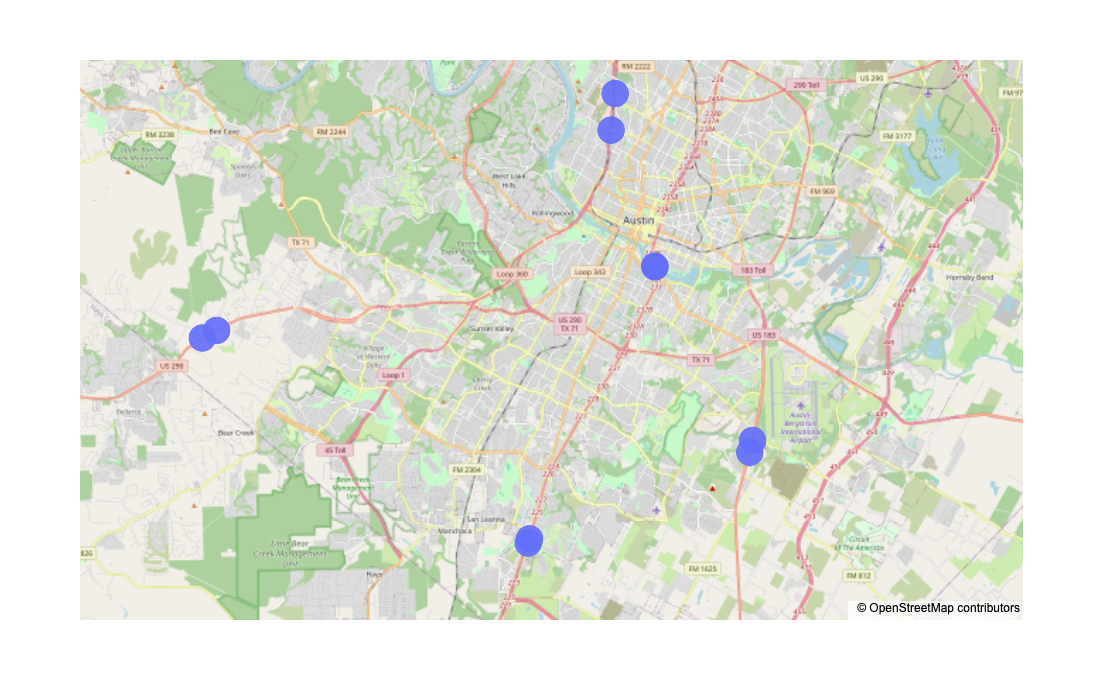

In [401]:
px.scatter_mapbox(
    austin_stations,
    lat='latitude', 
    lon='longitude',
    size_max=20,
    size='latitude',
    zoom=10.5,
    height=700,
    mapbox_style="open-street-map"
)

In [196]:
austin_df = df[df["station_id"].isin(austin_stations["station_id"])]
len(austin_df["station_id"].unique())

8

In [233]:
coordinates

,latitude,longitude
20,30137657,97797022
31,30137657,97797022
38,30179010,97688723
90,30135898,97797664
122,30251800,97736100
142,30135898,97797664
144,30324487,97755456
153,30251800,97736100
157,30179010,97688723
213,30221960,97955900
